Tuesday, June 13, 2023

This video shows how to manually implement back propogation in a multi layer perceptron.

docker container start sad_nightingale

[Building makemore Part 4: Becoming a Backprop Ninja](https://www.youtube.com/watch?v=q8SA3rM6ckI)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.__version__

'1.13.1'

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
lenOfWords = len(words)
print(lenOfWords)
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))

In [5]:
delimiter = '.'

In [6]:
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi[delimiter] = 0

In [7]:
itos = { c:i for i, c in stoi.items()}

In [8]:
vocab_size = len(itos)
print(vocab_size)

27


In [9]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + delimiter:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [10]:
thgttg = 42
manualSeed = 2147483647

In [11]:
import random
random.seed(thgttg)
random.shuffle(words)

In [12]:
n1 = int(0.8 * lenOfWords)
n2 = int(0.9 * lenOfWords)
print(n1, n2)

25626 28829


In [13]:
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
# ok boilerplate code is done, now we get to the action ...

In [15]:
torch.all??

Docstring:
all(input) -> Tensor

Tests if all elements in :attr:`input` evaluate to `True`.

.. note:: This function matches the behaviour of NumPy in returning
          output of dtype `bool` for all supported dtypes except `uint8`.
          For `uint8` the dtype of output is `uint8` itself.

Example::

    >>> a = torch.rand(1, 2).bool()
    >>> a
    tensor([[False, True]], dtype=torch.bool)
    >>> torch.all(a)
    tensor(False, dtype=torch.bool)
    >>> a = torch.arange(0, 3)
    >>> a
    tensor([0, 1, 2])
    >>> torch.all(a)
    tensor(False)

.. function:: all(input, dim, keepdim=False, *, out=None) -> Tensor
   :noindex:

For each row of :attr:`input` in the given dimension :attr:`dim`,
returns `True` if all elements in the row evaluate to `True` and `False` otherwise.

If :attr:`keepdim` is ``True``, the output tensor is of the same size
as :attr:`input` except in the dimension :attr:`dim` where it is of size 1.
Otherwise, :attr:`dim` is squeezed (see :func:`torch.squeeze`

In [16]:
torch.allclose??

Docstring:
allclose(input, other, rtol=1e-05, atol=1e-08, equal_nan=False) -> bool

This function checks if all :attr:`input` and :attr:`other` satisfy the condition:

.. math::
    \lvert \text{input} - \text{other} \rvert \leq \texttt{atol} + \texttt{rtol} \times \lvert \text{other} \rvert

elementwise, for all elements of :attr:`input` and :attr:`other`. The behaviour of this function is analogous to
`numpy.allclose <https://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html>`_

Args:
    input (Tensor): first tensor to compare
    other (Tensor): second tensor to compare
    atol (float, optional): absolute tolerance. Default: 1e-08
    rtol (float, optional): relative tolerance. Default: 1e-05
    equal_nan (bool, optional): if ``True``, then two ``NaN`` s will be considered equal. Default: ``False``

Example::

    >>> torch.allclose(torch.tensor([10000., 1e-07]), torch.tensor([10000.1, 1e-08]))
    False
    >>> torch.allclose(torch.tensor([10000., 1e-08]), torch.t

In [17]:
# utility function we weill use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate {str(app):5s} | maxdiff {maxdiff}')

In [18]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(manualSeed) # for reproducability

# the embedding table for the characters ...
C = torch.randn((vocab_size, n_embd), generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/ ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # using b1 just for fun, it's useless because of batch normalization

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

# Note: I am initializing many of these parameters in non-standard ways
# because sometimes initializing with e.g. all zeros could mask an incorrect
# implementation of the backward pass

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True



4137


In [19]:
batch_size = 32
n = batch_size # a sorter variable, also for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [20]:
# Xb.sum??
# Docstring:
# sum(dim=None, keepdim=False, dtype=None) -> Tensor

# See :func:`torch.sum`
# Type:      builtin_function_or_method

In [21]:
3 * 2 + 7

13

In [22]:
# Xb.max??
# Docstring:
# max(dim=None, keepdim=False) -> Tensor or (Tensor, Tensor)

# See :func:`torch.max`
# Type:      builtin_function_or_method

In [23]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear Layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# Batch Normalization Layer
bnmeani = 1/n * hprebn.sum(dim=0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1) * (bndiff2).sum(dim=0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-Linearity
h = torch.tanh(hpreact)

# Linear Layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(dim=1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(dim=1, keepdim=True)
counts_sum_inv = counts_sum**-1 # if we use (1.0 / counts_sum) instead then we can't get backprop to be bit exact ... 
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
    
# PyTorch retain_grad => Enables this Tensor to have their grad populated during backward(). 
# This is a no-op for leaf tensors

# afaik there is no cleaner way to do this ...
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, 
    norm_logits, logit_maxes, logits, h, hpreact, bnraw,
    bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
    embcat, emb]:
    t.retain_grad()
    
loss.backward()
loss



tensor(3.3513, grad_fn=<NegBackward0>)

### Exercise 1:

Backprop through the whole thing manually, backpropagating through exactly all of the variables
as they are defined in the forward pass above, one by one.

#### loss = -logprobs[range(n), Yb].mean()

In [24]:
print(n)
print(logprobs[range(n), Yb].shape)
print(logprobs.shape)
print(Yb.shape)
print(loss)

32
torch.Size([32])
torch.Size([32, 27])
torch.Size([32])
tensor(3.3513, grad_fn=<NegBackward0>)


In [25]:
Yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [26]:
someIndex = 19
print(Yb[someIndex].item())
print(logprobs[someIndex])
print(logprobs[someIndex, Yb[someIndex]])

9
tensor([-3.7835, -3.8599, -3.3530, -4.0229, -3.4052, -3.2706, -2.6978, -2.9681,
        -3.4067, -3.4181, -3.5741, -3.1179, -2.7734, -2.8910, -4.4534, -3.7855,
        -3.5936, -3.9189, -3.5440, -2.3793, -3.0322, -3.3747, -3.0861, -3.0590,
        -3.4481, -3.7783, -3.7195], grad_fn=<SelectBackward0>)
tensor(-3.4181, grad_fn=<SelectBackward0>)


dlogprobs will hold the derivative of the loss with respect to all the elements of logprobs. For this reason, it will also have the same shape as logprobs.

Now how does logprobs influence the loss? Remember Yb is just an array of all the correct indices of the next character.  

loss = -(a + b + c) / 3

loss = -a/3 - b/3 - c/3

So what is the derivative of the loss with respect to a?

dloss/da = -1/3

So the derivative is 1/n where n is the number of digits.

In [27]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs.shape

torch.Size([32, 27])

In [28]:
dlogprobs[range(n), Yb] = -1.0/n

In [29]:
1.0 / n

0.03125

In [30]:
dlogprobs[someIndex]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, -0.0312,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000])

In [31]:
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate True  | maxdiff 0.0


#### logprobs = probs.log()

![](images/dxlogx.png)

In our example, x is probs, so the local derivate of probs.log() is simply (1.0 / probs).

And because of the chain rule, we multiply that by dlogprobs:

In [32]:
dprobs = (1.0 / probs) * dlogprobs

In [33]:
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate True  | maxdiff 0.0


#### probs = counts * counts_sum_inv

In [34]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [35]:
# c = a * b, but with tensors:
# a[3x3] * b[3x1] --->
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b3
# a31*b3 a32*b3 a33*b3
# c[3x3]

In [36]:
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)

In [37]:
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate True  | maxdiff 0.0


In [38]:
dcounts = (counts_sum_inv * dprobs)

#### counts_sum_inv = counts_sum**-1 

![](images/ddx1_x.png)

In [39]:
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

In [40]:
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate True  | maxdiff 0.0


#### counts_sum = counts.sum(dim=1, keepdim=True)

In [41]:
# we need to add in the previous value we calculated for dcounts ... so use += 
dcounts += torch.ones_like(counts) * dcounts_sum

In [42]:
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate True  | maxdiff 0.0


#### counts = norm_logits.exp()

![](images/ddx_ex.png)

The derivate of norm_logits.exp() is norm_logits.exp() which is already in counts, so let's just use counts.

In [43]:
dnorm_logits = counts * dcounts

In [44]:
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate True  | maxdiff 0.0


#### norm_logits = logits - logit_maxes

In [45]:
# shapes are different ...
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [46]:
# c11 c12 c13 = a11 a12 a13 - b1
# c21 c22 c23 = a21 a22 a23 - b2
# c31 c32 c33 = a31 a32 a33 - b3

# so e.g. c32 = a32 - b3

In [47]:
dlogits = dnorm_logits.clone() # this is NOT our final derivative for dlogits!
dlogit_maxes = (-dnorm_logits).sum(dim=1, keepdim=True)

In [48]:
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate True  | maxdiff 0.0


#### logit_maxes = logits.max(dim=1, keepdim=True).values

In [49]:
# notice we use += because we need to add in the previous value
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

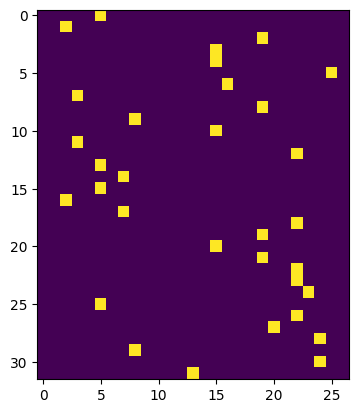

In [50]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

In [51]:
cmp('logits',dlogits,logits)

logits          | exact: True  | approximate True  | maxdiff 0.0


#### logits = h @ W2 + b2 

In [52]:
print(f'dlogits.shape => {dlogits.shape}')
print(f'h.shape =======> {h.shape}')
print(f'W2.shape ======> {W2.shape}')
print(f'(h@W2).shape ==> {(h@W2).shape}')
print(f'b2.shape ======> {b2.shape}')

dlogits.shape => torch.Size([32, 27])
h.shape =======> torch.Size([32, 64])
W2.shape ======> torch.Size([64, 27])
(h@W2).shape ==> torch.Size([32, 27])
b2.shape ======> torch.Size([27])


In [53]:
# dh must have the same shape as h 32x64
dh = dlogits @ W2.T

In [54]:
# dW2 must have the same shape as W2 64x27
dW2 = h.T @ dlogits

In [55]:
# db2 must have the same shape as b2 27
db2 = dlogits.sum(dim=0)

In [56]:
cmp('h',dh,h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

h               | exact: True  | approximate True  | maxdiff 0.0
W2              | exact: True  | approximate True  | maxdiff 0.0
b2              | exact: True  | approximate True  | maxdiff 0.0


#### h = torch.tanh(hpreact)

![](images/ddx_tanh.png)

Notice the derivate of tanh(z) is 1 - a**2, where a is the output of tanh, not the input.

In [57]:
# remember, the chain rule ... so multiply by dh
dhpreact = (1.0 - h**2) * dh

In [58]:
# I think this is not exact just due to some rounding differences ... 
cmp('hpreact', dhpreact, hpreact)

# We get this result ALMOST every time we restart the kernel and run all ...
# hpreact         | exact: False | approximate True  | maxdiff 4.656612873077393e-10

# hmm other times we can get this ..
# hpreact         | exact: False | approximate True  | maxdiff 9.313225746154785e-10

hpreact         | exact: False | approximate True  | maxdiff 9.313225746154785e-10


In [59]:
torch.all(dhpreact == hpreact.grad).item()

False

In [60]:
torch.allclose(dhpreact, hpreact.grad)

True

In [61]:
(dhpreact - hpreact.grad).abs().max().item()

9.313225746154785e-10

In [62]:
(dhpreact - hpreact.grad)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.3656e-11,
          0.0000e+00, -1.1642e-10],
        [ 0.0000e+00,  0.0000e+00, -5.8208e-11,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  5.8208e-11,  ...,  0.0000e+00,
         -2.9104e-11,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.3283e-10,  2.9104e-11,  0.0000e+00,  ...,  0.0000e+00,
         -1.1642e-10, -5.8208e-11],
        [ 7.2760e-12,  0.0000e+00,  0.0000e+00,  ..., -1.1642e-10,
         -8.7311e-11,  0.0000e+00]], grad_fn=<SubBackward0>)

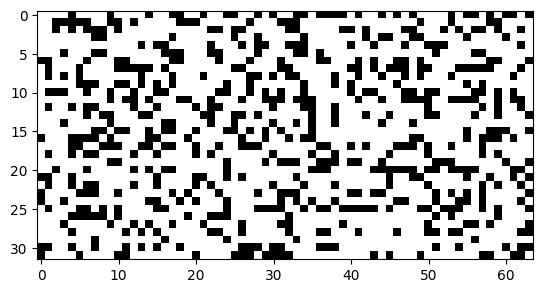

In [63]:
not_equal = torch.not_equal(dhpreact, hpreact.grad)
plt.imshow(not_equal, cmap='binary')
plt.show()
# white cells are equal ... why do we not see all white cells?

We now begin back propogation through the batch normalization layer. This is discussed in the paper 

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf)

![](images/BatchNormalizationLayer.png)
![](images/BatchNormalizingTransform.png)

#### hpreact = bngain * bnraw + bnbias

In [64]:
print(f'hpreact.shape => {hpreact.shape}')
print(f'bngain.shape => {bngain.shape}')
print(f'bnraw.shape => {bnraw.shape}')
print(f'(bngain * bnraw).shape => {(bngain*bnraw).shape}')
print(f'bnbias.shape => {bnbias.shape}')

hpreact.shape => torch.Size([32, 64])
bngain.shape => torch.Size([1, 64])
bnraw.shape => torch.Size([32, 64])
(bngain * bnraw).shape => torch.Size([32, 64])
bnbias.shape => torch.Size([1, 64])


In [65]:
dbngain = (bnraw * dhpreact).sum(dim=0, keepdim=True)

In [66]:
dbnraw = (bngain * dhpreact)

In [67]:
dbnbias = dhpreact.sum(dim=0, keepdim=True)

In [68]:
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)

bngain          | exact: False | approximate True  | maxdiff 2.3283064365386963e-09
bnraw           | exact: False | approximate True  | maxdiff 9.313225746154785e-10
bnbias          | exact: False | approximate True  | maxdiff 3.725290298461914e-09


#### bnraw = bndiff * bnvar_inv

In [69]:
print(f'bndiff.shape => {bndiff.shape}')
print(f'bnvar_inv.shape => {bnvar_inv.shape}')
print(f'(bndiff * bnvar_inv).shape => {((bndiff * bnvar_inv).shape)}')

bndiff.shape => torch.Size([32, 64])
bnvar_inv.shape => torch.Size([1, 64])
(bndiff * bnvar_inv).shape => torch.Size([32, 64])


In [70]:
dbndiff = bnvar_inv * dbnraw

In [71]:
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact: False | approximate False | maxdiff 0.0011086449958384037


In [72]:
dbnvar_inv = (bndiff * dbnraw).sum(dim=0, keepdim=True)

In [73]:
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

bnvar_inv       | exact: False | approximate True  | maxdiff 4.6566128730773926e-09


#### bnvar_inv = (bnvar + 1e-5)**-0.5

In [74]:
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv

In [75]:
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact: False | approximate True  | maxdiff 7.566995918750763e-10


#### bnvar = 1/(n-1) * (bndiff2).sum(dim=0, keepdim=True)

[Bessel's Correction](https://mathcenter.oxford.emory.edu/site/math117/besselCorrection/)

In [76]:
print(f'bnvar.shape ===> {bnvar.shape}')
print(f'bndiff2.shape => {bndiff2.shape}')

bnvar.shape ===> torch.Size([1, 64])
bndiff2.shape => torch.Size([32, 64])


In [77]:
# a11 a12
# a21 a22
# ----->
# b1, b2, where:
# b1 = 1/(n-1)*(a11 + a21)
# b2 = 1/(n-1)*(a12 + a22)

In [78]:
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar

In [79]:
cmp('bndiff2',dbndiff2, bndiff2)

bndiff2         | exact: False | approximate True  | maxdiff 2.3646862246096134e-11


#### bndiff2 = bndiff**2

In [80]:
bndiff.shape

torch.Size([32, 64])

In [81]:
# Notice we have to add in the previous calculation of bndiff with +=
dbndiff += (2*bndiff) * dbndiff2

In [82]:
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact: False | approximate True  | maxdiff 9.313225746154785e-10


#### bndiff = hprebn - bnmeani

In [83]:
hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([1, 64]))

In [84]:
dhprebn = dbndiff.clone()

In [85]:
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate False | maxdiff 0.001013938570395112


In [86]:
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(dim=0)

In [87]:
# we can actually just replace the above line with this ..
# because ..
# torch.ones_like(bndiff)
# is just multiplying by 1 ... 
dbnmeani = (-dbndiff).sum(dim=0)

In [88]:
cmp('bnmeani', dbnmeani, bnmeani)

bnmeani         | exact: False | approximate True  | maxdiff 1.862645149230957e-09


#### bnmeani = 1/n * hprebn.sum(dim=0, keepdim=True)

In [89]:
# again, we += this from the previous value ... 
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

In [90]:
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate True  | maxdiff 9.313225746154785e-10


So now we have finished back propagating through the batch normalization layer. We can now back propagate linear layer 1.

#### hprebn = embcat @ W1 + b1 

In [91]:
hprebn.shape, embcat.shape, W1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [92]:
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(dim=0)

In [93]:
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

embcat          | exact: False | approximate True  | maxdiff 1.3969838619232178e-09
W1              | exact: False | approximate True  | maxdiff 3.725290298461914e-09
b1              | exact: False | approximate True  | maxdiff 2.7939677238464355e-09


#### embcat = emb.view(emb.shape[0], -1) 

In [94]:
embcat.shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 3, 10]))

In [95]:
demb = dembcat.view(emb.shape)

In [96]:
cmp('emb', demb, emb)

emb             | exact: False | approximate True  | maxdiff 1.3969838619232178e-09


#### emb = C[Xb]

In [97]:
# forward pass: emb = C[Xb]
print(emb.shape, C.shape, Xb.shape)
print(Xb[:5])

torch.Size([32, 3, 10]) torch.Size([27, 10]) torch.Size([32, 3])
tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])


In [98]:
dC = torch.zeros_like(C)

In [99]:
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

In [100]:
cmp('C', dC, C)

C               | exact: False | approximate True  | maxdiff 4.6566128730773926e-09


Run all the comparison statements together to get the overview of how we did.

In [101]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate True  | maxdiff 0.0
probs           | exact: True  | approximate True  | maxdiff 0.0
counts_sum_inv  | exact: True  | approximate True  | maxdiff 0.0
counts_sum      | exact: True  | approximate True  | maxdiff 0.0
counts          | exact: True  | approximate True  | maxdiff 0.0
norm_logits     | exact: True  | approximate True  | maxdiff 0.0
logit_maxes     | exact: True  | approximate True  | maxdiff 0.0
logits          | exact: True  | approximate True  | maxdiff 0.0
h               | exact: True  | approximate True  | maxdiff 0.0
W2              | exact: True  | approximate True  | maxdiff 0.0
b2              | exact: True  | approximate True  | maxdiff 0.0
hpreact         | exact: False | approximate True  | maxdiff 9.313225746154785e-10
bngain          | exact: False | approximate True  | maxdiff 2.3283064365386963e-09
bnbias          | exact: False | approximate True  | maxdiff 3.725290298461914e-09
bnraw           | exact: False | ap

In [102]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.351276159286499 diff: 2.384185791015625e-07


In [103]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate True  | maxdiff 7.2177499532699585e-09


In [104]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [105]:
F.softmax(logits, 1)[0]

tensor([0.0641, 0.0855, 0.0202, 0.0512, 0.0192, 0.0922, 0.0254, 0.0364, 0.0173,
        0.0325, 0.0333, 0.0346, 0.0394, 0.0291, 0.0305, 0.0132, 0.0092, 0.0195,
        0.0155, 0.0580, 0.0481, 0.0214, 0.0264, 0.0670, 0.0610, 0.0273, 0.0226],
       grad_fn=<SelectBackward0>)

In [106]:
dlogits[0] * n

tensor([ 0.0641,  0.0855,  0.0202,  0.0512,  0.0192,  0.0922,  0.0254,  0.0364,
        -0.9827,  0.0325,  0.0333,  0.0346,  0.0394,  0.0291,  0.0305,  0.0132,
         0.0092,  0.0195,  0.0155,  0.0580,  0.0481,  0.0214,  0.0264,  0.0670,
         0.0610,  0.0273,  0.0226], grad_fn=<MulBackward0>)

In [107]:
dlogits[0].sum()

tensor(2.3283e-10, grad_fn=<SumBackward0>)

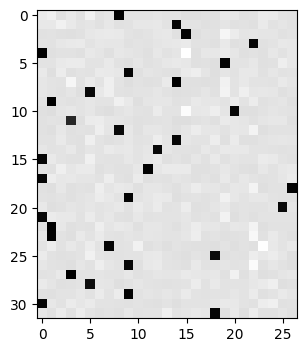

In [108]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [109]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [110]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate True  | maxdiff 6.984919309616089e-10


In [111]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [112]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

12297


In [113]:
%%time
# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

# CPU times: user 41min 7s, sys: 2.9 s, total: 41min 10s
# Wall time: 5min 23s

      0/ 200000: 3.8500
  10000/ 200000: 2.2031
  20000/ 200000: 2.3493
  30000/ 200000: 2.4731
  40000/ 200000: 2.0106
  50000/ 200000: 2.3401
  60000/ 200000: 2.3747
  70000/ 200000: 2.0174
  80000/ 200000: 2.3383
  90000/ 200000: 2.1910
 100000/ 200000: 2.0133
 110000/ 200000: 2.3770
 120000/ 200000: 2.0207
 130000/ 200000: 2.5074
 140000/ 200000: 2.2609
 150000/ 200000: 2.1258
 160000/ 200000: 1.9279
 170000/ 200000: 1.8082
 180000/ 200000: 1.9865
 190000/ 200000: 1.8651
CPU times: user 42min 52s, sys: 2.86 s, total: 42min 54s
Wall time: 5min 39s


### Finally, Let's run everything on the GPU!

In [114]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
else:
    device = torch.device("cpu")  # Fallback to CPU if GPU is not available
device

device(type='cuda')

In [115]:
# If you want to force device for the remaining code, do it here ...

Is there some way to get the above code running on the GPU WITHOUT adding in all of the .to(device) code to every line we create a new tensor??

#### We first of all need to load the dataset to the GPU

In [116]:
XtrGPU = Xtr.to(device)
YtrGPU = Ytr.to(device)

XdevGPU = Xdev.to(device)
YdevGPU = Ydev.to(device)

XteGPU = Xte.to(device)
YteGPU = Yte.to(device)

#### Then tweak the code to use the device

In [117]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g).to(device)
# Layer 1
W1 = (torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)).to(device)
b1 = (torch.randn(n_hidden,                        generator=g) * 0.1).to(device)
# Layer 2
W2 = (torch.randn((n_hidden, vocab_size),          generator=g) * 0.1).to(device)
b2 = (torch.randn(vocab_size,                      generator=g) * 0.1).to(device)
# BatchNorm parameters
bngain = (torch.randn((1, n_hidden))*0.1 + 1.0).to(device)
bnbias = (torch.randn((1, n_hidden))*0.1).to(device)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

12297


In [118]:
%%time
# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, XtrGPU.shape[0], (batch_size,), generator=g)
    Xb, Yb = XtrGPU[ix], YtrGPU[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.7795
  10000/ 200000: 2.1717
  20000/ 200000: 2.4130
  30000/ 200000: 2.4210
  40000/ 200000: 2.0331
  50000/ 200000: 2.2745
  60000/ 200000: 2.4246
  70000/ 200000: 2.0621
  80000/ 200000: 2.4008
  90000/ 200000: 2.1472
 100000/ 200000: 1.9258
 110000/ 200000: 2.2893
 120000/ 200000: 2.0140
 130000/ 200000: 2.4013
 140000/ 200000: 2.3603
 150000/ 200000: 2.1417
 160000/ 200000: 1.9309
 170000/ 200000: 1.8732
 180000/ 200000: 2.0348
 190000/ 200000: 1.9127
CPU times: user 11min 9s, sys: 279 ms, total: 11min 9s
Wall time: 11min 10s


Ok, that is ridiculous! Why is the above code running soo much slower than the CPU code? It is literally half the speed!! I am doubting it is even running on the GPU! 

Gonna redo the code a little differently ...

In [122]:
# doubt this really is even needed, but gonna run it anyways ...
g = None
C = None
W1 = None
b1 = None
W2 = None
b2 = None
bngain = None
bnbias = None

In [123]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g, device=device)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g, device=device) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g, device=device) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g, device=device) * 0.1
b2 = torch.randn(vocab_size,                      generator=g, device=device) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden), device=device)*0.1 + 1.0
bnbias = torch.randn((1, n_hidden), device=device)*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

12297


In [124]:
%%time
# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, XtrGPU.shape[0], (batch_size,), generator=g, device=device)
    Xb, Yb = XtrGPU[ix], YtrGPU[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.6193
  10000/ 200000: 2.5983
  20000/ 200000: 1.9748
  30000/ 200000: 2.4369
  40000/ 200000: 2.0644
  50000/ 200000: 2.6719
  60000/ 200000: 2.2973
  70000/ 200000: 2.2144
  80000/ 200000: 2.1684
  90000/ 200000: 2.0491
 100000/ 200000: 2.3221
 110000/ 200000: 1.6753
 120000/ 200000: 2.1570
 130000/ 200000: 2.1407
 140000/ 200000: 2.0796
 150000/ 200000: 2.1221
 160000/ 200000: 1.7140
 170000/ 200000: 2.3287
 180000/ 200000: 2.0945
 190000/ 200000: 2.2459
CPU times: user 11min 10s, sys: 182 ms, total: 11min 10s
Wall time: 11min 11s


I noticed as the above code ran, that there was 100% CPU utilization on 1 core ... why??

Sigh. No difference in performance! Keep digging ... !